In [12]:
import random
import sys

# This method can be tweaked for testing
def dice(n): # Returns n dice numbers (totally random) - tested
    return [random.randint(1, 6) for i in range(n)]


# Some tests for different scoring combos:

def unique(roll):
    u = []
    for r in roll:
        if r not in u:
            u.append(r)
    return u

def test_for_3oak(roll):
    u = unique(roll)
    for r in u:
        if roll.count(r) >= 3: # <<<<<<<<<< cases with >3 handled by player
            return True, r
    return False, 0

def test_for_3pairs(roll):
    u = unique(roll)
    twos = 0
    for r in u:
        if roll.count(r) == 2:
            twos += 1
    if twos == 3:
        return True
    return False

def test_for_23s(roll):
    u = unique(roll)
    threes = 0
    for r in u:
        if roll.count(r) == 3:
            threes += 1
    if threes == 2:
        return True
    return False

def test_for_run(roll):
    if len(unique(roll)) == 6:
        return True
    return False

# This is the base class, that implements a simple player who keeps 1s and 5s and rolls again if they have 3 or more dice left.
# To build a more complex player, one simply adds a child class and overrides the process_roll function.
class BasicPlayer:
    def __init__(self, name):
        self.name = name
        self.score = 0
        self.temp_score = 0
        self.keeping = []

    def process_roll(self, roll):
        # Knows temp score, score and current roll. Adds dice to self.keeping and optionally rolls again.
        # Returns: (roll_again (bool), fail (bool - true if no points scored))
        # Go through dice looking for high scoring patterns << Add patterns
        self.kept = 0 # How many dice kept (must be at least 1 else turn ends)
        for d in roll:
            if d == 1:
                self.keeping.append(1)
                self.kept += 1
                self.temp_score += 100
            if d == 5:
                self.keeping.append(5)
                self.kept += 1
                self.temp_score += 50
        if (self.kept) == 0:
            return (False, True) # Scored no points this roll
        elif len(self.keeping) > 3:
            return (False, False) # Scored points, 2 or fewer dice remain (so don't roll again)
        else:
            return (True, False) # Scored points, and there are 3 or more dice to play with - recomment roll again.

    def turn(self, verbose=False):
        # Reset some variables
        self.temp_score = 0
        self.keeping = []
        # Roll the dice
        roll = dice(6)
        if verbose:print('Player %s: rolled ' % self.name + str(roll))
        # Process the roll. If roll_again is true, keep rolling until it isn't or a roll fails
        roll_again, fail = self.process_roll(roll)
        if fail:
            if verbose:print('     - %s: No points this roll, total score: ' % self.name + str(self.score))
            self.temp_score = 0
        elif roll_again:
            while roll_again:
                if verbose:print('     - %s: Keeping ' % self.name + str(self.keeping) + ' for temp_score of ' + str(self.temp_score) + ', total score: ' + str(self.score))
                # If all 6 used must roll again, with 6 dice (so empty keeping)
                if len(self.keeping) == 6:
                    self.keeping = []
                roll = dice(6 - len(self.keeping))
                if verbose:print('     - %s: rolled ' % self.name + str(roll))
                roll_again, fail = self.process_roll(roll)
                if fail:
                    if verbose:print('     - %s: No points this roll, total score: ' % self.name + str(self.score))
                    self.temp_score = 0
                # Otherwise, roll_again determines how many times this loop runs
        # Update the score - turn has ended.
        self.score += self.temp_score
        if verbose:print('     - %s: Turn over. ' % self.name + 'Kept:'+ str(self.keeping) + ', turn score:' + str(self.temp_score) + ', total score: ' + str(self.score))



class AllRules(BasicPlayer):

    def pull_highs(self, roll):
        # 2 3OAKS
        if test_for_23s(roll):
            for d in roll:
                self.keeping.append(d)
                roll.remove(d)
                self.kept += 1
                self.temp_score += 2500

        # 3 pairs:
        if test_for_3pairs(roll):
            for d in roll:
                self.keeping.append(d)
                roll.remove(d)
                self.kept += 1
                self.temp_score += 2000

        # Run (1, 2, 3, 4, 5, 6)
        if test_for_run(roll):
            for d in roll:
                self.keeping.append(d)
                roll.remove(d)
                self.kept += 1
                self.temp_score += 1500
        return roll

    def pull_3oak(self, roll):
        # 3oak:
        thr, num = test_for_3oak(roll)
        if thr:
            for n in [num, num, num]:
                self.keeping.append(num)
                roll.remove(num)
                self.kept += 1
            s = num*100 # The score for this
            if num == 1: s = 1000 # one is a special case
            # If there are any extras of that number (more than three total), we double the score for each
            while roll.count(num) > 0:
                self.keeping.append(num)
                roll.remove(num)
                self.kept += 1
                s = s*2
            self.temp_score += s
        return roll


    def process_roll(self, roll):
        # Knows temp score, score and current roll. Adds dice to self.keeping and optionally rolls again.
        # Returns: (roll_again (bool), fail (bool - true if no points scored))
        # Go through dice looking for high scoring patterns << Add patterns
        self.kept = 0 # How many dice kept (must be at least 1 else turn ends)

        roll = self.pull_highs(roll)

        roll = self.pull_3oak(roll)


        # 1s and 5s:
        for d in roll:
            if d == 1:
                self.keeping.append(1)
                self.kept += 1
                self.temp_score += 100
            if d == 5:
                self.keeping.append(5)
                self.kept += 1
                self.temp_score += 50


        if (self.kept) == 0:
            return (False, True) # Scored no points this roll
        if len(self.keeping) == 6:
            return (True, False) # Used all 6 dice - must roll again
        elif len(self.keeping) > 3:
            return (False, False) # Scored points, 2 or fewer dice remain (so don't roll again)
        else:
            return (True, False) # Scored points, and there are 3 or more dice to play with - recomment roll again.


In [13]:
def score_player(player, n_rounds):
    for i in range(n_rounds):
        player.turn()

    return(player.score/float(n_rounds))

In [14]:
p = AllRules('Baseline') # Flaw: plays with 3 left always
score_player(p, 100000) # Gives average score

751.0325

In [15]:
p = BasicPlayer('Baseline') # Flaw: plays with 3 left always
score_player(p, 100000) # Gives average score

213.862

(array([9.1886e+04, 2.1040e+03, 1.1800e+02, 1.5350e+03, 3.6540e+03,
        6.2700e+02, 5.2000e+01, 5.0000e+00, 9.0000e+00, 1.0000e+01]),
 array([    0.,  1415.,  2830.,  4245.,  5660.,  7075.,  8490.,  9905.,
        11320., 12735., 14150.]),
 <a list of 10 Patch objects>)

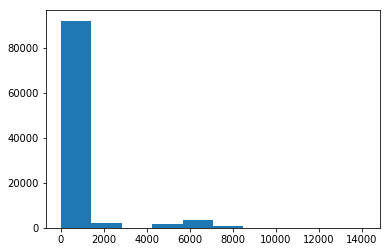

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

scores = []
for i in range(100000):
    p.score = 0
    p.turn()
    scores.append(p.score)

plt.hist(scores)


(array([28462., 40572., 12542.,  2971.,  6884.,   808.,   435.,  1017.,
           90.,  6219.]),
 array([   0.,  260.,  520.,  780., 1040., 1300., 1560., 1820., 2080.,
        2340., 2600.]),
 <a list of 10 Patch objects>)

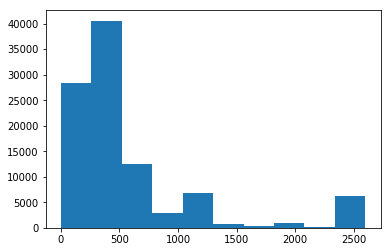

In [5]:
import numpy as np
s = np.asarray(scores)
s2 = s.clip(0, 2600)
plt.hist(s2)

In [6]:
import pandas as pd

In [7]:
df = pd.DataFrame(scores)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3621ac6e48>]],
      dtype=object)

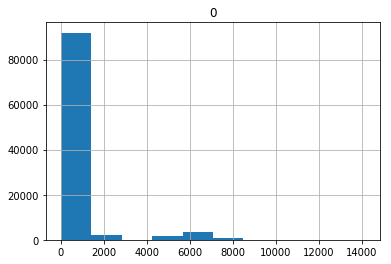

In [8]:
df.hist()

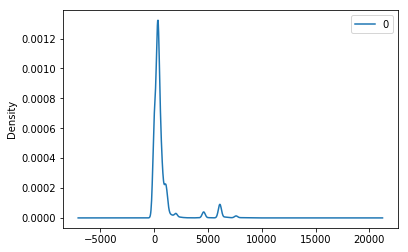

In [9]:
df.plot(kind='density')

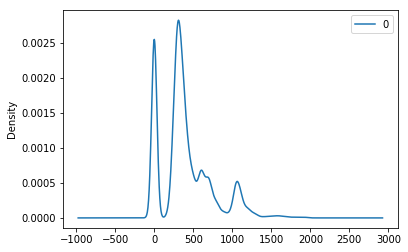

In [11]:
df.loc[df[0]<2000].plot(kind='density')

In [27]:
df.loc[df[0] > 1000].count()/1000

0    15.117
dtype: float64

In [29]:
df.loc[df[0] > 5000].count()/1000

0    4.301
dtype: float64

In [39]:
df.loc[df[0] == 3100].count()/1000

0    0.003
dtype: float64

In [40]:
df.mean()

0    739.697
dtype: float64

In [41]:
ns = []
score = 0
n = 0
for s in scores:
    score += s
    n += 1
    if score > 10000:
        ns.append(n)
        score = 0
        n = 0

In [42]:
ns[:10]

[24, 7, 14, 21, 13, 11, 24, 14, 23, 29]

In [44]:
np.mean(ns)

15.74228589420655

In [45]:
np.median(ns)

15.0

In [46]:

class AllRulesThreshForThreeOne(AllRules):

    def __init__(self, name, thresh3, thresh1):
        self.name = name
        self.score = 0
        self.temp_score = 0
        self.keeping = []
        self.thresh3 = thresh3
        self.thresh1 = thresh1

    def process_roll(self, roll):
        self.kept = 0

        roll = self.pull_highs(roll)

        roll = self.pull_3oak(roll)


        # 1s and 5s:
        for d in roll:
            if d == 1:
                self.keeping.append(1)
                self.kept += 1
                self.temp_score += 100
            if d == 5:
                self.keeping.append(5)
                self.kept += 1
                self.temp_score += 50


        if (self.kept) == 0:
            return (False, True) # Scored no points this roll
        if len(self.keeping) == 6:
            return (True, False) # Used all 6 dice - must roll again
        elif len(self.keeping) == 5 and self.temp_score > self.thresh1:
            return (True, False) # One dice left - risk it for the brisket. Not a good idea generally
        elif len(self.keeping) > 3:
            return (False, False) # Scored points, 2 or fewer dice remain (so don't roll again)
        elif len(self.keeping) == 3 and self.temp_score > self.thresh3:
            return (False, False) # Don't roll with 3 left if score is above thresh
        else:
            return (True, False) # Scored points, and there are 3 or more dice to play with - recomment roll again.






array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f015a9b4080>]],
      dtype=object)

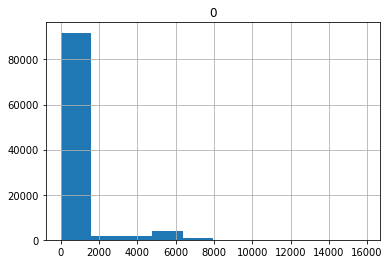

In [49]:
p = AllRulesThreshForThreeOne('name', 500, 20000) # bank 500+ instead of rolling 3 dice

scores = []
for i in range(100000):
    p.score = 0
    p.turn()
    scores.append(p.score)
    
df = pd.DataFrame(scores)
df.hist()

In [50]:
df.describe()

,0
count,100000.00000
mean,786.07450
std,1418.14656
min,0.00000
25%,250.00000
50%,350.00000
75%,650.00000
max,15900.00000


Much better mean. Lets see the other metrics

In [51]:
ns = []
score = 0
n = 0
for s in scores:
    score += s
    n += 1
    if score > 10000:
        ns.append(n)
        score = 0
        n = 0

In [52]:
np.mean(ns)

14.878738282993602

In [53]:
np.median(ns)

14.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f013f6207b8>,
      dtype=object)

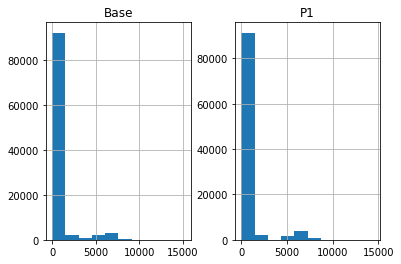

In [55]:
p1 = AllRulesThreshForThreeOne('name', 500, 20000) # bank 500+ instead of rolling 3 dice
pb = AllRules('Baseline')

bscores = []
scores = []
for i in range(100000):
    pb.score = 0
    pb.turn()
    bscores.append(pb.score)
    p1.score = 0
    p1.turn()
    scores.append(p1.score)
    
df = pd.DataFrame({'Base':bscores, 'P1':scores})
df.hist()

In [56]:
df.describe()

,Base,P1
count,100000.000000,100000.000000
mean,752.887500,791.899500
std,1385.996897,1425.303274
min,0.000000,0.000000
25%,250.000000,250.000000
50%,350.000000,350.000000
75%,650.000000,650.000000
max,15200.000000,14500.000000


In [60]:
bw = 0
p1w = 0

bscore = 0
p1score = 0

for i in range(len(scores)):
    bscore += bscores[i]
    p1score += scores[i]
    if (bscore > 10000) or (p1score > 10000):
        if bscore>p1score:
            bw += 1
        else:
            p1w += 1
        bscore = 0
        p1score = 0
            
    

In [61]:
bw

4104

In [62]:
p1w

4644

In [63]:
p1w/(p1w+bw)

0.5308641975308642

In [78]:
import operator

def compare_players(players, nt):
    names = [p.name for p in players]
    pscores = {}
    for p in players:
        scores = []
        for i in range(nt):
            p.score = 0
            p.turn()
            scores.append(p.score)
        pscores[p.name] = scores
    
    wins = {}
    ss = {}
    for n in names:
        ss[n] = 0
        wins[n] = 0
        
    for i in range(nt):
        for n in names:
            ss[n] += pscores[n][i]
            if max(ss.values())>10000:
                winner = max(ss.items(), key=operator.itemgetter(1))[0]
                wins[winner] += 1
                for n in names:
                    ss[n] = 0
        
    return (wins, pscores)

p1 = AllRulesThreshForThreeOne('name', 500, 20000) # bank 500+ instead of rolling 3 dice
pb = AllRules('Baseline')
    
wins, scores = compare_players([p1, pb], 100000)
df = pd.DataFrame(scores)
df.describe()

,name,Baseline
count,100000.00000,100000.000000
mean,790.90100,752.786500
std,1430.36468,1385.246115
min,0.00000,0.000000
25%,250.00000,250.000000
50%,350.00000,350.000000
75%,650.00000,650.000000
max,16500.00000,16550.000000


In [79]:
wins

{'name': 4744, 'Baseline': 4192}

In [88]:
class AllRulesThreshForThreeOneOnly5inDireStraits(AllRules):

    def __init__(self, name, thresh3, thresh1):
        self.name = name
        self.score = 0
        self.temp_score = 0
        self.keeping = []
        self.thresh3 = thresh3
        self.thresh1 = thresh1

    def process_roll(self, roll):
        self.kept = 0

        roll = self.pull_highs(roll)

        roll = self.pull_3oak(roll)


        # 1s and 5s:
        for d in roll:
            if d == 1:
                self.keeping.append(1)
                self.kept += 1
                self.temp_score += 100
        for d in roll:
            if d == 5 and (self.kept == 0 or self.kept > 2):
                self.keeping.append(5)
                self.kept += 1
                self.temp_score += 50


        if (self.kept) == 0:
            return (False, True) # Scored no points this roll
        if len(self.keeping) == 6:
            return (True, False) # Used all 6 dice - must roll again
        elif len(self.keeping) == 5 and self.temp_score > self.thresh1:
            return (True, False) # One dice left - risk it for the brisket. Not a good idea generally
        elif len(self.keeping) > 3:
            return (False, False) # Scored points, 2 or fewer dice remain (so don't roll again)
        elif len(self.keeping) == 3 and self.temp_score > self.thresh3:
            return (False, False) # Don't roll with 3 left if score is above thresh
        else:
            return (True, False) # Scored points, and there are 3 or more dice to play with - recomment roll again.

In [89]:
pn = AllRulesThreshForThreeOneOnly5inDireStraits('dump5s', 500, 10000)
po = AllRulesThreshForThreeOne('keep5s', 500, 10000)

In [90]:
wins, scores = compare_players([pn, po, pb], 100000)
df = pd.DataFrame(scores)
print(df.mean())
wins

dump5s      805.726
keep5s      775.637
Baseline    737.743
dtype: float64


{'dump5s': 3891, 'keep5s': 3505, 'Baseline': 3180}

First really interesting result for me!

In [96]:
class AllRulesThreshForThreeRisks1(AllRules):

    def __init__(self, name, thresh3, thresh1):
        self.name = name
        self.score = 0
        self.temp_score = 0
        self.keeping = []
        self.thresh3 = thresh3
        self.thresh1 = thresh1

    def process_roll(self, roll):
        self.kept = 0

        roll = self.pull_highs(roll)

        roll = self.pull_3oak(roll)


        # 1s and 5s:
        for d in roll:
            if d == 1:
                self.keeping.append(1)
                self.kept += 1
                self.temp_score += 100
        for d in roll:
            if d == 5 and (self.kept == 0 or self.kept > 2):
                self.keeping.append(5)
                self.kept += 1
                self.temp_score += 50


        if (self.kept) == 0:
            return (False, True) # Scored no points this roll
        if len(self.keeping) == 6:
            return (True, False) # Used all 6 dice - must roll again
        elif len(self.keeping) == 5 and self.temp_score < self.thresh1:
            return (True, False) # One dice left - risk it for the brisket. Not a good idea generally, but risks if low score
        elif len(self.keeping) > 3:
            return (False, False) # Scored points, 2 or fewer dice remain (so don't roll again)
        elif len(self.keeping) == 3 and self.temp_score > self.thresh3:
            return (False, False) # Don't roll with 3 left if score is above thresh
        else:
            return (True, False) # Scored points, and there are 3 or more dice to play with - recommend roll again.

In [105]:
prisky = AllRulesThreshForThreeRisks1('risks1', 500, 500)

In [107]:
wins, scores = compare_players([pn, po, prisky], 1000000)
df = pd.DataFrame(scores)
print(df.mean())
wins

dump5s    806.9842
keep5s    786.3161
risks1    808.7040
dtype: float64


{'dump5s': 37134, 'keep5s': 35162, 'risks1': 37422}

In [108]:
pn1 = AllRulesThreshForThreeOneOnly5inDireStraits('dump5s1', 500, 10000)
pn2 = AllRulesThreshForThreeOneOnly5inDireStraits('dump5s2', 500, 10000)
pn3 = AllRulesThreshForThreeOneOnly5inDireStraits('dump5s3', 500, 10000)
pn4 = AllRulesThreshForThreeOneOnly5inDireStraits('dump5s4', 500, 10000)
pn5 = AllRulesThreshForThreeOneOnly5inDireStraits('dump5s5', 500, 10000)
pn6 = AllRulesThreshForThreeOneOnly5inDireStraits('dump5s6', 500, 10000)
pns = [pn1, pn2, pn3, pn4, pn5, pn6]
po = AllRulesThreshForThreeOne('keep5s', 500, 10000)


In [109]:
ts = [250, 300, 400, 500, 600, 700, 1000]
for t in ts:
    prisky = AllRulesThreshForThreeRisks1('risks1', 500, t)
    wins, scores = compare_players([pn1, pn2, pn3, pn4, pn5, pn6, prisky], 100000)
    df = pd.DataFrame(scores)
    print('T: '+str(t) + ', Score: ' + str(df.mean()['risks1']) + ', Win Percentage: ' + str(wins['risks1']/sum(wins.values())))

T: 250, Score: 806.5575, Win Percentage: 0.14400627820286444
T: 300, Score: 806.114, Win Percentage: 0.14294136914510316
T: 400, Score: 806.4185, Win Percentage: 0.14531384350816853
T: 500, Score: 813.452, Win Percentage: 0.14512115258677144
T: 600, Score: 813.5875, Win Percentage: 0.14729844228638467
T: 700, Score: 803.6135, Win Percentage: 0.14635579937304075
T: 1000, Score: 790.662, Win Percentage: 0.14083766191071076


In [112]:
prisky = AllRulesThreshForThreeRisks1('risks1', 500, 700)
wins, scores = compare_players([pn1, pn2, pn3, pn4, pn5, pn6, prisky], 3000000)
wins

{'dump5s1': 65559,
 'dump5s2': 64978,
 'dump5s3': 65293,
 'dump5s4': 65080,
 'dump5s5': 65238,
 'dump5s6': 65160,
 'risks1': 66318}

In [113]:
df = pd.DataFrame(scores)
df.mean()

dump5s1    807.679317
dump5s2    806.118700
dump5s3    806.327633
dump5s4    806.029383
dump5s5    806.765667
dump5s6    807.170067
risks1     802.735333
dtype: float64

In [116]:
prisky = AllRulesThreshForThreeRisks1('risks1', 500, 700)
wins2, scores2 = compare_players([pn1, prisky], 500000)
wins2

{'dump5s1': 23411, 'risks1': 23071}

In [117]:
df2 = pd.DataFrame(scores2)
df2.mean()

dump5s1    804.3118
risks1     801.2165
dtype: float64